### Tempering SMC for AUC problem - Variant 1 dataset

We adapt and apply the tempering SMC algorithm by Ridgway et al 2016 to Variant 1 dataset.


Some comments

- We try two different scheduling: log-scheduling and bisection search. Both seem to give an AUC of 85% / 86% when the other parameters are fixed. My guess is that bisection search can be further improved by tuning.

- With T = 1000 iterations, N = 50 particles and minibatches of size 1000, the AUC is about 86% and the running time of SMC algorithm is around 1min and 30sec on my PC. Note that I use numba package to speed things up.

- With T = 500 iterations, N = 50 particles and minibatches of size 200, the AUC is about 84% and the running time of SMC algorithm is about 35seconds on my PC. Note that I use numba package to speed things up.

- Note that one could parallelise the algorithm (e.g. generation of particles) and significantly improve the performance.

- We may also get a significantly higher AUC if we spend time tunign stuff! Gamma sequence is completely arbitrary, there may exists better choices. Surely, the one from Ridgway et al would work better, but it is hard to code. Similarly for kappa sequence in the markov kernels: for instance, we could decrease it according to some smart criterion, or may also use covariance matrix of particles - but this has to be estimated and we would need a lot of particles and I think it is not worth it. 

- In the algorithm, we minimise a AUC risk (i.e. how many samples we misrank) instead of optimising the standard AUC (i.e. how many we rank right). BUt should definitely be equivalent.



#### Loading dataset, formatting etc

In [2]:
# Song Liu (song.liu@bristol.ac.uk), 01-06-2023
# All rights reserved.

# load csv files from archive folder
import matplotlib.pyplot as plt
from numpy import  *
import pandas as pd

#base = pd.read_csv('archive/Variant I.csv') #use this in general
base = pd.read_csv('Variant I.csv')
# remove 'income', 'customer_age', 'employment_status' columns as they are protected
base = base.drop(columns=['income', 'customer_age', 'employment_status'])
# convert categorical variables in 'payment_type' to integers
base['payment_type'] = base['payment_type'].astype('category')
base['housing_status'] = base['housing_status'].astype('category')
base['source'] = base['source'].astype('category')
base['device_os'] = base['device_os'].astype('category')

cat_columns = base.select_dtypes(['category']).columns
base[cat_columns] = base[cat_columns].apply(lambda x: x.cat.codes)

# Ben's formatting

missing_value = -10 # missing values are replaced by this!

def mean_std_scale(x): return (x - x.mean())/x.std()

df = pd.DataFrame(index=range(len(base)), columns=[])
df['fraud_bool'] = base['fraud_bool'].copy().astype(float)
df['name_email_similarity'] = base['name_email_similarity'].copy()

## scale
prev = base['prev_address_months_count'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['prev_address_months_count'] = prev.copy()

prev = base['current_address_months_count'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['current_address_months_count'] = prev.copy()

df['days_since_request'] = mean_std_scale(base['days_since_request']).copy()
df['intended_balcon_amount'] = mean_std_scale(base['intended_balcon_amount']).copy()

pt = pd.get_dummies(base, columns=['payment_type'])
for i in range(5): df[f'payment_type_{i}'] = pt[f'payment_type_{i}'].astype(float)


df['zip_count_4w'] = mean_std_scale(base['zip_count_4w'].copy().astype(float))

## not sure these should be mean/std scaled tbh... maybe min/max scaling would be better
## https://www.dropbox.com/scl/fo/vg4b2hyapa9o9ajanbfl3/AL1RUfD1rAb5RBvgFQwc8eI/bank-account-fraud/documents?dl=0&preview=datasheet.pdf&rlkey=2r99po055q5pjbg1934ga0c8i&subfolder_nav_tracking=1
for col in ['velocity_6h', 'velocity_24h', 'velocity_4w',
            'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
            'credit_risk_score']:
    df[col] = mean_std_scale(base[col]).copy()

df['email_is_free'] = base['email_is_free'].copy().astype(float)


pt = pd.get_dummies(base, columns=['housing_status'])
for i in range(7): df[f'housing_status_{i}'] = pt[f'housing_status_{i}'].astype(float)

df['phone_home_valid'] = base['phone_home_valid'].copy().astype(float)
df['phone_mobile_valid'] = base['phone_mobile_valid'].copy().astype(float)


prev = base['bank_months_count'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['bank_months_count'] = prev.copy()

df['has_other_cards'] = base['has_other_cards'].copy().astype(float)
df['foreign_request'] = base['foreign_request'].copy().astype(float)


## not sure these should be mean/std scaled tbh... maybe min/max scaling would be better
## https://www.dropbox.com/scl/fo/vg4b2hyapa9o9ajanbfl3/AL1RUfD1rAb5RBvgFQwc8eI/bank-account-fraud/documents?dl=0&preview=datasheet.pdf&rlkey=2r99po055q5pjbg1934ga0c8i&subfolder_nav_tracking=1
for col in ['proposed_credit_limit']:
    df[col] = mean_std_scale(base[col]).copy()


df['source'] = base['source'].copy().astype(float)

prev = base['session_length_in_minutes'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['session_length_in_minutes'] = prev.copy()


pt = pd.get_dummies(base, columns=['device_os'])
for i in range(5): df[f'device_os_{i}'] = pt[f'device_os_{i}'].astype(float)

df['keep_alive_session'] = base['keep_alive_session'].copy().astype(float)

prev = base['device_distinct_emails_8w'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['device_distinct_emails_8w'] = prev.copy()

df['device_fraud_count'] = base['device_fraud_count'].copy().astype(float)

pt = pd.get_dummies(base, columns=['month'])
for i in range(8): df[f'month_{i}'] = pt[f'month_{i}'].astype(float)

# base = base.to_numpy()

## SMC tempering with log-scheduling

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from numba import jit
from sklearn.metrics import roc_auc_score

X = df.drop(df.filter(like='fraud_bool',axis=1).columns.to_list(), axis=1)
y = df["fraud_bool"]
y = np.where(y > np.median(y), 1, -1)

# standardise
scaler = StandardScaler()
X = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=20)

def create_minibatches(X, y, batch_size):
    skf = StratifiedKFold(n_splits=len(X) // batch_size)
    minibatches = []
    for _, test_index in skf.split(X, y):
        X_batch, y_batch = X[test_index], y[test_index]
        minibatches.append((X_batch, y_batch))
    return minibatches


batch_size = 1000  # batch size
minibatches = create_minibatches(X_train, y_train, batch_size)

# prior distribution
def prior_distribution(theta):
    return stats.norm.pdf(theta, 0, 100).prod()

# AUC objective function
@jit(nopython=True, fastmath=True)
def auc_risk(theta, X, Y):
    score = np.dot(X, theta)
    positive_scores = score[Y == 1]
    negative_scores = score[Y == -1]

    misranked_pairs = 0
    for i in range(len(positive_scores)):
        for j in range(len(negative_scores)):
            if positive_scores[i] < negative_scores[j]:
                misranked_pairs += 1

    return misranked_pairs / (len(positive_scores) * len(negative_scores))

def posterior_distribution(theta, gamma, X, Y):
    return prior_distribution(theta) * np.exp(-gamma * auc_risk(theta, X, Y))

# Importance weights - -100 * can be seen as annealing constant
def importance_weights(particles, gamma_prev, gamma_current, X, Y, importance_annealing):
    return np.exp(-importance_annealing * (gamma_current - gamma_prev) * np.array([auc_risk(particle, X, Y) for particle in particles]))

# systematic resampling. Can also use simple resampling, but it does not seem to work that well
@jit(nopython=True, fastmath=True)
def resample(particles, weights):
    N = len(particles)
    positions = (np.arange(N) + np.random.random()) / N
    indices = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indices[i] = j
            i += 1
        else:
            j += 1
    return particles[indices]

#def resample(particles, weights):
#    indices = np.random.choice(len(particles), size=len(particles), p=weights/np.sum(weights))
#    return particles[indices]

#Logarithmic Schedule for gamma: not sure whether there are better choices !!! For sure, the one in Ridgway et al, but it is hard to code

def logarithmic_schedule(T, gamma_initial, gamma_final):
    return gamma_initial + (gamma_final - gamma_initial) * (np.log(np.arange(0, T + 2) + 1) / np.log(T + 2))


#exponential schedule seems working much worse!
#def exponential_schedule(T, gamma_initial, gamma_final):
#    return gamma_initial * (gamma_final / gamma_initial) ** (np.arange(1, T + 3) / (T + 2))


# SMC algorithm
def smc_sampler(N, T, gammas, minibatches, kappas, importance_annealing):
    particles = np.random.normal(loc = 0, scale  = 100, size = (N, minibatches[0][0].shape[1]))
    weights = np.ones(N) / N
    #auc_risks_min = []
    #auc_risks_median = []
    ess = []

    for t in range(1, T + 1):
        gamma_prev = gammas[t - 1]
        gamma_current = gammas[t]
        current_annealing = importance_annealing[t]
        
        # Shuffle minibatches 
        np.random.shuffle(minibatches)
        X_batch, y_batch = minibatches[0]
        
        weights = importance_weights(particles, gamma_prev, gamma_current, X_batch, y_batch, current_annealing)
        weights = weights / np.sum(weights)
        ess.append(1 / (np.sum(weights ** 2)))
        
        # resample only if ESS drops below threshold
        #if ess[-1] < 0.9 * N:
        #    particles = resample(particles, weights)
            
        particles = resample(particles, weights)
        
        # Compute covariance of particles
        for i in range(N):
            proposed_particle = particles[i] + np.random.multivariate_normal(np.zeros(X_batch.shape[1]), kappas[t]* (X_batch.shape[1]+1) * np.diag(np.ones(X_batch.shape[1])))
            acceptance_prob = min(1, posterior_distribution(proposed_particle, gamma_current, X_batch, y_batch) / posterior_distribution(particles[i], gamma_current, X_batch, y_batch))
            if np.random.rand() < acceptance_prob:
                particles[i] = proposed_particle
        
        #auc_min = np.min(np.array([auc_risk(particle, X_batch, y_batch) for particle in particles]))
        #auc_risks_min.append(auc_min)
        #auc_median = np.median(np.array([auc_risk(particle, X_batch, y_batch) for particle in particles]))
        #auc_risks_median.append(auc_median)
    
    return particles, ess

# define parameters for the SMC sampler
T = 1000
N = 50

#importance_annealing = np.arange(100,100 + T+3)
importance_annealing = np.repeat(100, T+3) 
#imprtance_annealing = importance_annealing[::-1]

# log schedule
gamma_initial = 0
gamma_final = 800
gammas = logarithmic_schedule(T, gamma_initial, gamma_final)


kappas = 100 * np.arange(1, T + 3) ** (- 1. ) #this is very heuristic - simulations work better than with kappas \equiv 1
#kappas = np.repeat(1 , T + 3)


# Train
particles, ess = smc_sampler(N, T, gammas, minibatches, kappas, importance_annealing)


/tmp/ipykernel_36691/2138480801.py:109: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / np.sum(weights)
/tmp/ipykernel_36691/2138480801.py:109: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / np.sum(weights)


### Evaluation on test set and plotting

##### Boxplot of AUC values on test set for each of the final particles

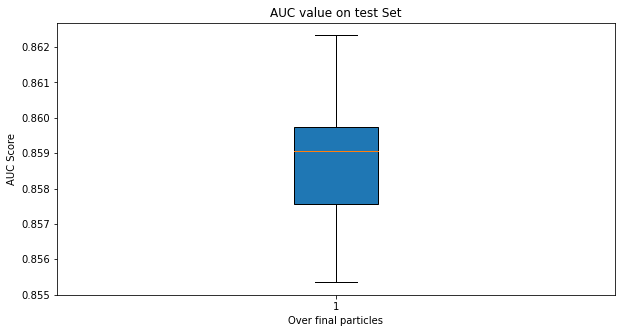

In [4]:
# Evaluate on the test set
auc_scores_test = []
for particle in particles:
    score = np.dot(X_test, particle)
    auc = roc_auc_score(y_test, score) # if we want "real auc" - i.e. no auc risk - evaluation 
    #auc = auc_risk(particle, X_test, y_test)
    auc_scores_test.append(auc)

# Create a boxplot for the AUC scores on the test set
plt.figure(figsize=(10, 5))
plt.boxplot(auc_scores_test, vert=True, patch_artist=True)
plt.xlabel('Over final particles')
plt.ylabel('AUC Score')
plt.title('AUC value on test Set')
plt.show()

##### Effective Sample Size - this is just to check how SMC works

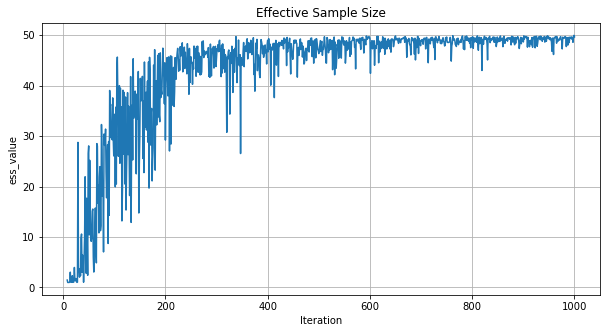

In [5]:
# Analyze the Results
plt.figure(figsize=(10, 5))

plt.plot(range(1, T + 1), ess)
plt.title('Effective Sample Size')
plt.xlabel('Iteration')
plt.ylabel('ess_value')
plt.grid(True)

ESS may sometimes be wiggling because we are using minibatches... this should not be a problem

### SMC tempering with bisection search: scheduling s.t. ESS is fixed

Perhaps this type of scheduling is more robust to different datasets.

In [10]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from numba import jit
from sklearn.metrics import roc_auc_score


def create_minibatches(X, y, batch_size):
    skf = StratifiedKFold(n_splits=len(X) // batch_size)
    minibatches = []
    for _, test_index in skf.split(X, y):
        X_batch, y_batch = X[test_index], y[test_index]
        minibatches.append((X_batch, y_batch))
    return minibatches

X = df.drop(df.filter(like='fraud_bool',axis=1).columns.to_list(), axis=1)
y = df["fraud_bool"]
y = np.where(y > np.median(y), 1, -1)

# standardise
scaler = StandardScaler()
X = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=20)

batch_size = 500  
minibatches = create_minibatches(X_train, y_train, batch_size)

def prior_distribution(theta):
    return stats.norm.pdf(theta, 0, 100).prod()

@jit(nopython=True, fastmath=True)
def auc_risk(theta, X, Y):
    score = np.dot(X, theta)
    positive_scores = score[Y == 1]
    negative_scores = score[Y == -1]

    misranked_pairs = 0
    for i in range(len(positive_scores)):
        for j in range(len(negative_scores)):
            if positive_scores[i] < negative_scores[j]:
                misranked_pairs += 1

    return misranked_pairs / (len(positive_scores) * len(negative_scores))

def posterior_distribution(theta, gamma, X, Y):
    return prior_distribution(theta) * np.exp(-gamma * auc_risk(theta, X, Y))

def importance_weights(particles, gamma_prev, gamma_current, X, Y, importance_annealing):
    return np.exp(-importance_annealing * (gamma_current - gamma_prev) * np.array([auc_risk(particle, X, Y) for particle in particles]))

@jit(nopython=True, fastmath=True)
def resample(particles, weights):
    N = len(particles)
    positions = (np.arange(N) + np.random.random()) / N
    indices = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indices[i] = j
            i += 1
        else:
            j += 1
    return particles[indices]

def calculate_ess(weights):
    normalized_weights = weights / np.sum(weights)
    ess = 1.0 / np.sum(normalized_weights ** 2)
    return ess

def next_gamma(current_param, target_ess, particles, X, Y, importance_annealing, tolerance=1e-5):
    low, high = current_param, current_param + 1  #turns out the range is important!!!
    while high - low > tolerance:
        mid = (low + high) / 2
        weights = np.exp(-importance_annealing * (mid - current_param) * np.array([auc_risk(particle, X, Y) for particle in particles]))
        ess = calculate_ess(weights)
        if ess < target_ess:
            high = mid
        else:
            low = mid
    return (low + high) / 2

def smc_sampler(N, T, target_ess_ratio, minibatches, kappas, importance_annealing, tolerance=1e-5):
    particles = np.random.normal(loc=0, scale=100, size=(N, minibatches[0][0].shape[1]))
    current_param = 0.0
    target_ess = target_ess_ratio * N
    ess_values = []
    gammas = []

    for t in range(1, T + 1):
        # shuffle minibatches
        np.random.shuffle(minibatches)
        X_batch, y_batch = minibatches[0]

        # find the next gamma
        next_param = next_gamma(current_param, target_ess, particles, X_batch, y_batch, importance_annealing[t], tolerance)
        gammas.append(next_param)
        weights = np.exp(-importance_annealing[t] * (next_param - current_param) * np.array([auc_risk(particle, X_batch, y_batch) for particle in particles]))
        weights /= np.sum(weights)
        ess = calculate_ess(weights)
        ess_values.append(ess)

        # resample
        particles = resample(particles, weights)
        
        #update parameter
        current_param = next_param

        # move particles
        for i in range(N):
            proposed_particle = particles[i] + np.random.multivariate_normal(np.zeros(X_batch.shape[1]), kappas[t] * (X_batch.shape[1] + 1) * np.diag(np.ones(X_batch.shape[1])))
            acceptance_prob = min(1, posterior_distribution(proposed_particle, current_param, X_batch, y_batch) / posterior_distribution(particles[i], current_param, X_batch, y_batch))
            if np.random.rand() < acceptance_prob:
                particles[i] = proposed_particle
    
    return particles, ess_values, gammas

# Define parameters for the SMC sampler
T = 1000
N = 50
target_ess_ratio = 0.9
importance_annealing = np.repeat(100, T + 3)
kappas = 100 * np.arange(1, T + 3) ** (-1.)

# Train
particles, ess_values, gammas = smc_sampler(N, T, target_ess_ratio, minibatches, kappas, importance_annealing)

# Print ESS values to verify
#print(ess_values)


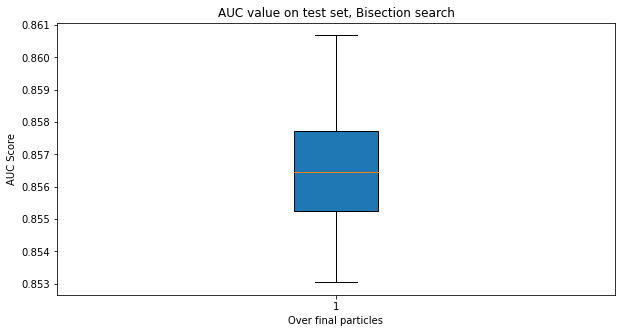

In [11]:
# Evaluate on the test set
auc_scores_test = []
for particle in particles:
    score = np.dot(X_test, particle)
    auc = roc_auc_score(y_test, score) # if we want "real auc" - i.e. no auc risk - evaluation 
    #auc = auc_risk(particle, X_test, y_test)
    auc_scores_test.append(auc)

# Create a boxplot for the AUC scores on the test set
plt.figure(figsize=(10, 5))
plt.boxplot(auc_scores_test, vert=True, patch_artist=True)
plt.xlabel('Over final particles')
plt.ylabel('AUC Score')
plt.title('AUC value on test set, Bisection search')
plt.show()

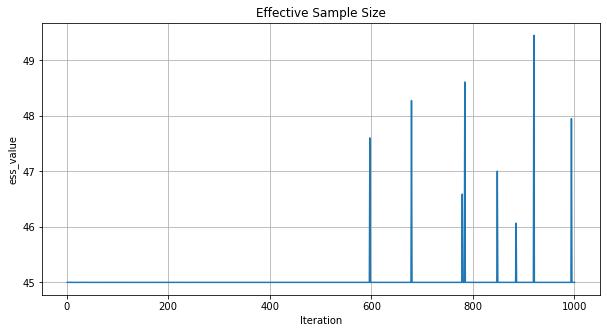

In [12]:
# Analyze the Results
plt.figure(figsize=(10, 5))

plt.plot(range(1, T + 1), ess_values)
plt.title('Effective Sample Size')
plt.xlabel('Iteration')
plt.ylabel('ess_value')
plt.grid(True)

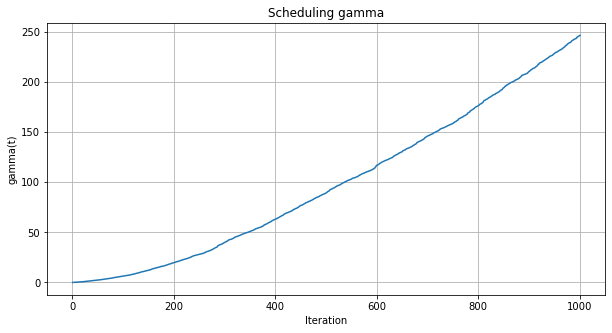

In [13]:
# Analyze the Results
plt.figure(figsize=(10, 5))

plt.plot(range(1, T + 1), gammas)
plt.title('Scheduling gamma')
plt.xlabel('Iteration')
plt.ylabel('gamma(t)')
plt.grid(True)